<a href="https://colab.research.google.com/github/waghts95/Simple_blockchain/blob/master/TusharWagh_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob


# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 4)
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/content/drive/My Drive/Photos/train')
print("***")
print(train_files, train_targets)
valid_files, valid_targets = load_dataset('/content/drive/My Drive/Photos/valid')
print("###")
print(valid_files, valid_targets)
test_files, test_targets = load_dataset('/content/drive/My Drive/Photos/test')
print("----")
print(test_files)
print(test_targets)
print("jugug")
# get the burn classes
# We only take the characters from a starting position to remove the path
burn_classes = [item[11:-1] for item in sorted(glob("/content/drive/My Drive/Photos/train/*/"))]

# print statistics about the dataset
print('There are %d total categories.' % len(burn_classes))
print(burn_classes)
print('There are %s total burn images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))

for file in train_files: assert('.DS_Store' not in file)

***
['/content/drive/My Drive/Photos/train/Buland Darwaza/22.fatehpur-sikri.jpg'
 '/content/drive/My Drive/Photos/train/Rumi darwaza/39.019ADDOR0004755U00000000[SVC1].jpg'
 '/content/drive/My Drive/Photos/train/Buland Darwaza/31.1490942832_rotates_shareiq_255_1381164476.896856.JPG'
 '/content/drive/My Drive/Photos/train/Buland Darwaza/23.5739585618_75ea53d63d_b.jpg'
 '/content/drive/My Drive/Photos/train/Rumi darwaza/18.511a2376e4b015f836876db2_600x315.jpg'
 '/content/drive/My Drive/Photos/train/Jama Masjid Gate/39.1200px-Jama_Masjid_-_In_the_Noon.jpg'
 '/content/drive/My Drive/Photos/train/Bara Imambara/17.1836px-Outer_premises_of_Bara_Imambara_%28Imambara_of_Asaf-ud-daula_in_Lucknow%29_on_a_summer_afternoon.jpg'
 '/content/drive/My Drive/Photos/train/Rumi darwaza/48.Satkhanda-near-Rumi-Darwaza_Lucknow-1024x683.jpg'
 '/content/drive/My Drive/Photos/train/Rumi darwaza/23.8444648710_291931aa1e_b.jpg'
 '/content/drive/My Drive/Photos/train/Jama Masjid Gate/26.5004051769_d69374c84b_b.jpg'

---
<a id='step1'></a>
## Step 1: Convert Dataset and Test Standard Classification with ResNet

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect the contents of our burn images to get a feeling of what a standard model thinks about these images.

Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [0]:
from keras.applications.resnet50 import ResNet50   

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

W0803 15:45:50.765014 139797848262528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 15:45:50.813907 139797848262528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 15:45:50.842868 139797848262528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0803 15:45:50.901467 139797848262528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0803 15:45:50.902886

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [0]:
from keras.preprocessing import image                  
from tqdm import tqdm

# Note: modified these two functions, so that we can later also read the inception tensors which 
# have a different format 
def path_to_tensor(img_path, width=224, height=224):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(width, height))
    # convert PIL.Image.Image type to 3D tensor with shape (width, heigth, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, width, height, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, width=224, height=224):
    list_of_tensors = [path_to_tensor(img_path, width, height) for img_path in tqdm(img_paths)]
    print(list_of_tensors)
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [0]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path 
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Standard classification

As can be seen by the classes produced on a standard ResNet with pre-trained ImageNet weights, the output on the burn images is not giving us a lot of information and we cannot really use this.

In [0]:
# Translation of categories taken from https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
##import imagenet1000_dict 

burn_files_short = train_files[:30]

for file in burn_files_short:
    prediction_id = ResNet50_predict_labels(file)
    ##prediction_text = imagenet1000_dict.id_to_human[prediction_id]
    ##print(prediction_text)
    print(prediction_id)
    

873
497
873
873
698
497
698
497
668
663
663
698
698
698
698
698
698
698
698
873
873
497
698
442
663
698
698
497
698
594


In [0]:
# helpers for training CNNs taken from 
# https://github.com/madhavajay/nd889/blob/master/2_deep_learning/1_dog_breed_classifier/dog_app.ipynb
# many thanks to Jay for these helper functions

import keras
import timeit

# graph the history of model.fit
def show_history_graph(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show() 

# callback to show the total time taken during training and for each epoch
class EpochTimer(keras.callbacks.Callback):
    train_start = 0
    train_end = 0
    epoch_start = 0
    epoch_end = 0
    
    def get_time(self):
        return timeit.default_timer()

    def on_train_begin(self, logs={}):
        self.train_start = self.get_time()
 
    def on_train_end(self, logs={}):
        self.train_end = self.get_time()
        print('Training took {} seconds'.format(self.train_end - self.train_start))
 
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start = self.get_time()
 
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_end = self.get_time()
        print('Epoch {} took {} seconds'.format(epoch, self.epoch_end - self.epoch_start))

### Pre-process the Data
We rescale the images by dividing every pixel in every image by 255.

In [0]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

  0%|          | 0/168 [00:00<?, ?it/s]

[array([[[[149., 111.,  92.],
         [140., 102.,  83.],
         [138., 100.,  81.],
         ...,
         [201., 219., 241.],
         [201., 219., 241.],
         [202., 218., 241.]],

        [[163., 105.,  85.],
         [157.,  99.,  79.],
         [155.,  97.,  77.],
         ...,
         [201., 219., 241.],
         [201., 219., 241.],
         [203., 219., 242.]],

        [[172., 127.,  98.],
         [171., 126.,  97.],
         [173., 128.,  99.],
         ...,
         [201., 219., 241.],
         [201., 219., 241.],
         [202., 218., 241.]],

        ...,

        [[165., 144., 123.],
         [190., 165., 145.],
         [177., 150., 129.],
         ...,
         [187., 159., 138.],
         [197., 166., 138.],
         [195., 165., 139.]],

        [[245., 236., 203.],
         [248., 233., 202.],
         [233., 217., 184.],
         ...,
         [199., 181., 167.],
         [188., 167., 146.],
         [188., 160., 138.]],

        [[255., 238., 210.],
      

  0%|          | 0/16 [00:00<?, ?it/s]

[array([[[[234., 240., 252.],
         [237., 243., 255.],
         [235., 241., 253.],
         ...,
         [250., 254., 253.],
         [250., 254., 253.],
         [252., 255., 255.]],

        [[234., 240., 252.],
         [237., 243., 255.],
         [235., 241., 253.],
         ...,
         [250., 254., 253.],
         [250., 254., 253.],
         [252., 255., 255.]],

        [[234., 240., 252.],
         [237., 243., 255.],
         [235., 241., 253.],
         ...,
         [250., 254., 253.],
         [250., 254., 253.],
         [252., 255., 255.]],

        ...,

        [[186., 168.,  58.],
         [189., 169.,  72.],
         [184., 162.,  76.],
         ...,
         [135., 154.,  36.],
         [124., 143.,  25.],
         [123., 142.,  24.]],

        [[189., 173.,  75.],
         [190., 172.,  86.],
         [247., 228., 152.],
         ...,
         [145., 160.,  43.],
         [142., 157.,  40.],
         [130., 145.,  28.]],

        [[195., 176., 107.],
      

100%|██████████| 16/16 [00:03<00:00,  3.54it/s]

[array([[[[202., 206., 217.],
         [202., 206., 217.],
         [204., 208., 219.],
         ...,
         [175., 190., 197.],
         [168., 183., 190.],
         [162., 177., 184.]],

        [[202., 206., 217.],
         [203., 207., 218.],
         [204., 208., 219.],
         ...,
         [177., 192., 199.],
         [169., 184., 191.],
         [165., 180., 187.]],

        [[202., 206., 217.],
         [204., 208., 219.],
         [204., 208., 219.],
         ...,
         [176., 191., 198.],
         [168., 183., 190.],
         [165., 180., 187.]],

        ...,

        [[161., 151.,  98.],
         [113., 109.,  84.],
         [ 85.,  85.,  47.],
         ...,
         [104.,  98.,  98.],
         [ 59.,  59.,  51.],
         [254., 250., 213.]],

        [[ 85.,  81.,  34.],
         [138., 134.,  99.],
         [108.,  99.,  70.],
         ...,
         [ 33.,  33.,  31.],
         [  2.,   8.,   8.],
         [ 60.,  53.,  43.]],

        [[103.,  98.,  60.],
      

### Imports

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint 

import matplotlib.pyplot as plt                        
%matplotlib inline                               


#### Results from previous project

TODO Must be deleted later

1. The first extension experiment was with an exact copy of the previous ResNet architecture, just using the InceptionV3 bottleneck network upfront. This resulted in a test accuracy of: 82.7751%, i.e. worse than the Resnet50. The optimum result was already reached after 8 epochs, meaning that the architecture again did serious overfitting. In follow up experiments, this accuracy changed sometimes. One result was 80.3828%.

2. The second extension experiment was changing the network architecture. I tried, not to use the GlobalAveragePooling layer, but instead flatten the data and then connect another dense layer. Although the number of parameters were not so high (around 500,000), this model ran into the problem of resource allocation and could not be solved.

3. The third experiment was keeping the GlobalAveragePooling, but add another dense layer with dropouts. This resulted in an accuracy of 80.8612%. Again worse than before. 

4. I tested the XCeption network with a top network using two LeakyReLus and a fully connected layer with 512 nodes. This resulted in an accuracy of 84.0909%, which is comparable to the ResNet50 performance, but involves a much more complicated network and longer training times. As can be seen in the figures, this network reached its accurcy peak for validation quite early and overfitted afterwards.

TODO: Playing around with batch size and optimizer.




### 9. Step Data Augmentation with Finetuning

As mentioned above I had a look at this tutorial [Keras](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). However, it was not possible for me to build the network based on this information.
So, I did a research on the Slack channels and found the excellent notebook and app of [Jay Madhava](https://github.com/madhavajay/nd889/blob/master/2_deep_learning/1_dog_breed_classifier/dog_app.ipynb).
Most parts of the following code are taken from there, but with my own modifications and experiments to learn the transfer and fine tuning.


In [0]:
# InceptionV3 uses 299 x 299 images instead of the 224 x 224 above
# So we need to generate another set of input tensors.
from keras.applications.inception_v3 import preprocess_input
from tqdm import tqdm

def paths_to_inception_tensor(img_paths, width=299, height=299):
    list_of_tensors = [preprocess_input(path_to_tensor(img_path, width, height)) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

inception_test_tensors = paths_to_inception_tensor(test_files)

100%|██████████| 16/16 [00:03<00:00,  3.59it/s]


In [0]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# TODO: Need to align with directories at the top!

img_width, img_height = 299, 299
batch_size = 8
num_classes = 4
train_dir = '/content/drive/My Drive/Photos/train'
valid_dir = '/content/drive/My Drive/Photos/valid'

# Data augmentation basically in the same way it was introduced with the cifar-10 dataset
# Here we also use shear and zoom as the images are larger.
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Same operation on the validation set
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)

Found 174 images belonging to 4 classes.
Found 167 images belonging to 4 classes.


In [0]:
import math

# Load Inception model without the top layers
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze all layers so that the weights cannot be updated
for layer in base_model.layers:
    layer.trainable = False

# Construct our own model on top of Inception network
# First use same architecture as above with just GlobalAveragePooling and a dense layer
output = base_model.output
print(output)
output = GlobalAveragePooling2D()(output)
print("###########")
print(output)
#output = Dense(512, activation='relu')(output)
top_layers = Dense(4, activation='softmax')(output)
print("###########")
print(output)

finetune_model = Model(inputs=base_model.input, outputs=top_layers)

finetune_model.summary() # prints Summary

finetune_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0803 15:48:36.890024 139797848262528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



87916544/87910968 [==============================] - 1s 0us/step


W0803 15:48:53.198554 139797848262528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Tensor("mixed10/concat:0", shape=(?, ?, ?, 2048), dtype=float32)
###########
Tensor("global_average_pooling2d_1/Mean:0", shape=(?, 2048), dtype=float32)
###########
Tensor("global_average_pooling2d_1/Mean:0", shape=(?, 2048), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________

In [0]:
!mkdir saved_models

mkdir: cannot create directory ‘saved_models’: File exists


W0803 15:49:07.303431 139797848262528 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training Samples: 174 Validation Samples: 168 Batch Size: 8 Training Steps: 22 Validation Steps: 21
Epoch 1/20
22/22 [==============================] - 119s 5s/step - loss: 1.3868 - acc: 0.3845 - val_loss: 1.4581 - val_acc: 0.4192
Epoch 0 took 119.03133582800001 seconds
Epoch 2/20
22/22 [==============================] - 110s 5s/step - loss: 1.2244 - acc: 0.4184 - val_loss: 1.3196 - val_acc: 0.3713
Epoch 1 took 110.07764024699964 seconds
Epoch 3/20
22/22 [==============================] - 110s 5s/step - loss: 1.1368 - acc: 0.5398 - val_loss: 1.2269 - val_acc: 0.3593
Epoch 2 took 109.92380798800014 seconds
Epoch 4/20
22/22 [==============================] - 109s 5s/step - loss: 0.9154 - acc: 0.6669 - val_loss: 1.3713 - val_acc: 0.2814
Epoch 3 took 108.95714149199966 seconds
Epoch 5/20
22/22 [==============================] - 110s 5s/step - loss: 0.8874 - acc: 0.6610 - val_loss: 1.0864 - val_acc: 0.5329
Epoch 4 took 110.0638113949999 seconds
Epoch 6/20
22/22 [============================

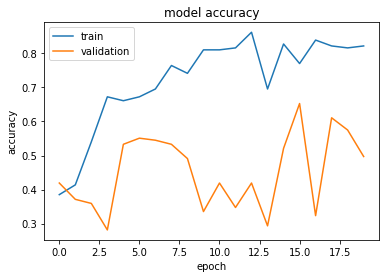

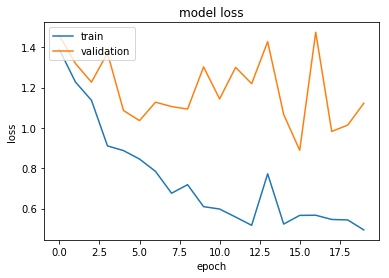

OSError: ignored

In [0]:
steps = math.ceil(train_tensors.shape[0]/batch_size)
validation_steps = math.ceil(valid_tensors.shape[0]/batch_size)
print('Training Samples: {} Validation Samples: {} Batch Size: {} Training Steps: {} Validation Steps: {}'.format(
      train_tensors.shape[0], valid_tensors.shape[0], batch_size, steps, validation_steps))

epochs = 20
epochtimer = EpochTimer()

# TODO: Continuously save best model!

hist = finetune_model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    validation_steps=validation_steps,
    callbacks=[epochtimer])

show_history_graph(hist)

top_model_file = 'saved_models/weights.best.{}.hdf5'.format('inceptionv3_top')
finetune_model.save(top_model_file)

In [0]:
predictions = [np.argmax(finetune_model.predict(np.expand_dims(feature, axis=0))) for feature in inception_test_tensors]

print(predictions)
# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

[3, 2, 0, 3, 3, 2, 3, 3, 1, 1, 3, 2, 2, 0, 3, 3]
Test accuracy: 43.7500%


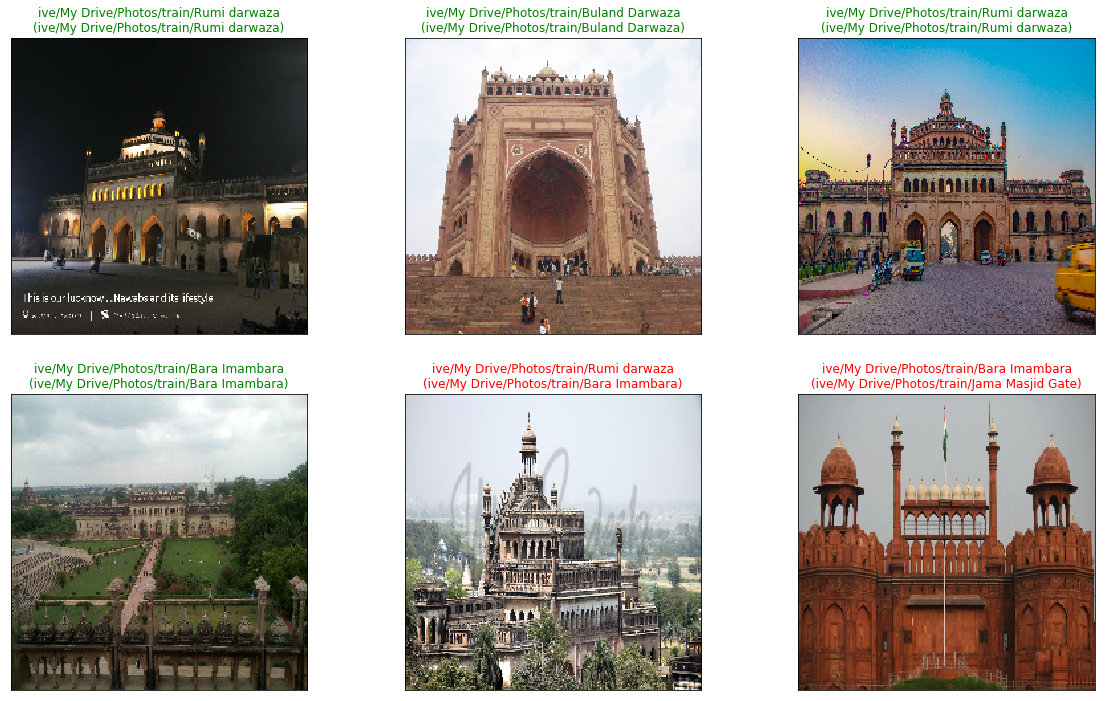

In [0]:
# Display some of the result images with correct or incorrect classification
fig = plt.figure(figsize=(20, 12))
for i, idx in enumerate(np.random.choice(test_tensors.shape[0], size=6, replace=False)):
    ax = fig.add_subplot(2, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_tensors[idx]))
    true_idx = np.argmax(test_targets[idx])
    pred_idx = predictions[idx]
    ax.set_title("{}\n({})".format(burn_classes[pred_idx], burn_classes[true_idx]),
                                  color=("green" if pred_idx == true_idx else "red"))